In [1]:
from shapely.geometry import Polygon, Point
import itertools
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
import numpy as np
import shapely.wkt as wkt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from tqdm import tqdm
from skimage.measure import label, regionprops
import os
import dask
import time
import gc
import re
from rioxarray.exceptions import NoDataInBounds

In [2]:
import distributed
dask.config.set({"distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_": 0})
dask.config.set(scheduler='processes')

In [3]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))

print(os.environ["MALLOC_TRIM_THRESHOLD_"])

#os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

0


In [4]:
import xarray as xr
import rioxarray as riox
from xrspatial import convolution, focal, hillshade
from skimage.transform import resize
from dask.distributed import LocalCluster, Client

In [5]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-2h36g8cc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-6gisbj_9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-6g_md_pa', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-9k3fak6g', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-ox7ekq3q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-psd01n35', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34689,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:40005,Total threads: 2
Dashboard: http://127.0.0.1:36953/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:43535,


In [6]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

def calc_tpi(dtm, inner_r, outer_r, values=True):
    cellsize_x, cellsize_y = convolution.calc_cellsize(dtm)
    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_r, inner_r)
    tpi = dtm - focal.apply(dtm, kernel)
    if values:
        return tpi.values
    else:
        return tpi

def calc_ndvi(ms, values=True):
    ndvi = (ms.sel(band=4).astype('float') - ms.sel(band=3).astype('float'))\
            / (ms.sel(band=4).astype('float') + ms.sel(band=3).astype('float'))
    if values:
        return ndvi.values
    else:
        return ndvi

In [7]:
from collections import namedtuple
from operator import mul

try:
    reduce = reduce
except NameError:
    from functools import reduce # py3k

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist)
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(max_size, max_rectangle_size(hist), key=area)
    return max_size

def max_rectangle_size(histogram):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    >>> f = max_rectangle_size
    >>> f([5,3,1])
    (3, 2)
    >>> f([1,3,5])
    (3, 2)
    >>> f([3,1,5])
    (5, 1)
    >>> f([4,8,3,2,0])
    (3, 3)
    >>> f([4,8,3,1,1,0])
    (3, 3)
    >>> f([1,2,1])
    (1, 3)
    Algorithm is "Linear search using a stack of incomplete subproblems" [1].
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(max_size, (top().height, (pos - top().start)),
                               key=area)
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(max_size, (height, (pos - start)), key=area)

    return max_size

def area(size):
    return reduce(mul, size)

In [8]:
outDIR = './cnn_pred_results/'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [9]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' #'cuda'# 'cpu'# 
model_fnl = 'deeplabplus'
res_fnl = 5
inputs_fnl = ['rgb', 'tpi', 'ndvi'] 
preprocess = True
prob_thresh = 0.5

In [10]:
#past_subset = None
past_subset = ['22E', 'CN']

img_f_dict = {
    '5W': {
        'group_1': {
            'rgb': '/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_5W_MS/CPER_202109_5W_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_dsm.tif'
        }
    },
    '29-30': {
        'group_1': {
            'rgb': '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_29_30_MS/CPER_202109_29_30_North_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_DSM.tif'
        },
        'group_2': {
            'rgb': '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_29_30_MS/CPER_202109_29_30_South_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_DSM.tif'
        }
    },
    '22W': {
        'group_1': {
            'rgb': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif'
        },
        'group_2': {
            'rgb': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif'
        }
    },
    '22E': {
        'group_1': {
            'rgb': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif'
        },
        'group_2': {
            'rgb': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif'
        },
        'group_3': {
            'rgb': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_DSM.tif'
        }
    },
    'CN': {
        'group_1': {
            'rgb': '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight2_202109_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight2_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight2_202109_RGB_DSM.tif'
        },
        'group_2': {
            'rgb': '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight3_202109_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight2_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight3_202109_RGB_DSM.tif'
        },
        'group_3': {
            'rgb': '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight4_202109_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight3_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight4_202109_RGB_DSM.tif'
        },
        'group_4': {
            'rgb': '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight5_202109_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight3_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight5_202109_RGB_DSM.tif'
        },
        'group_5': {
            'rgb': '/mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight5_202109_RGB_ortho.tif',
            'ms': '/mnt/d/202109/outputs/202109_CN_MS/CPER_202109_CN_Flight4_MS_ortho.tif',
            'dsm': '/mnt/d/202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight5_202109_RGB_DSM.tif'
        }
    }
}

if past_subset is not None:
    img_f_dict_tmp = img_f_dict.copy()
    img_f_dict = {}
    for k in img_f_dict_tmp:
         if k in past_subset:
                img_f_dict[k] = img_f_dict_tmp[k]

cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [11]:
full_buff_size = 25
full_tile_size = 100
tile_size = 256
buff_size = 64
chunk_size = 500

In [12]:
# load best saved checkpoint
if res_fnl == 2:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')
else:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '_' + str(res_fnl) + 'cm.pth')

if DEVICE == 'cpu':
    best_model = best_model.cpu()
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

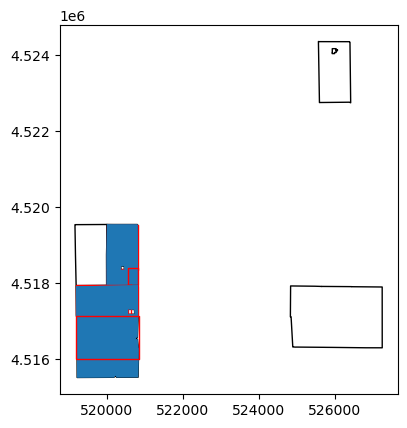

  0%|                                                                                     | 0/2 [00:00<?, ?it/s]



----------
Pasture: 22E



  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

---
Group: group_1




100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.17it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.87it/s]


running row: 0 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34007.87it/s]


running row: 1 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 72454.39it/s]


running row: 2 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 60205.32it/s]


running row: 3 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43741.29it/s]


running row: 4 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 69136.88it/s]


running row: 5 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 71493.82it/s]


running row: 6 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50264.63it/s]


running row: 7 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 59167.30it/s]


running row: 8 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 68015.74it/s]


running row: 9 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 62601.55it/s]


running row: 10 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 69136.88it/s]


running row: 11 of 12




100%|██████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50737.55it/s]

 33%|█████████████████████████▎                                                  | 1/3 [02:42<05:25, 162.98s/it]

Pasture-group finished!
---
Group: group_2


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.38 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.39 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

running row: 0 of 5




  0%|                                                                                     | 0/7 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.85it/s]


running row: 1 of 5




100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 52616.72it/s]


running row: 2 of 5




100%|██████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 47051.49it/s]


running row: 3 of 5




  0%|                                                                                     | 0/7 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 7/7 [04:16<00:00, 36.63s/it]


running row: 4 of 5




  0%|                                                                                     | 0/7 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 14%|███████████                                                                  | 1/7 [01:19<07:59, 79.95s/it]

 29%|██████████████████████                                                       | 2/7 [01:54<04:25, 53.20s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 43%|█████████████████████████████████                                            | 3/7 [02:37<03:14, 48.73s/it]

 57%|████████████████████████████████████████████                                 | 4/7 [03:14<02:11, 43.8

Pasture-group finished!
---
Group: group_3




100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 140.43it/s]


100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 223.52it/s]


running row: 0 of 5




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.37 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.40 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.40 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING

running row: 1 of 5




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.39 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.41 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.41 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING

running row: 2 of 5




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING

running row: 3 of 5




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.35 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING

running row: 4 of 5




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▎                                                  | 1/3 [01:51<03:43, 111.70s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [02:17<01:01, 61.21s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [02:53<00:00, 57.74s/it]

 50%|█████████████████████████████████████▌                                     | 1/2 [34:13<34:13, 2053.50s/it]

Pasture-group finished!


----------
Pasture: CN



  0%|                                                                                     | 0/5 [00:00<?, ?it/s]

---
Group: group_1


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.37 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

running row: 0 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:40<09:24, 40.34s/it]

 13%|██████████▏                                                                 | 2/15 [01:02<06:27, 29.82s/it]

 20%|███████████████▏                                                            | 3/15 [01:36<06:18, 31.53s/it]

 27%|████████████████████▎                                                       | 4/15 [02:01<05:18, 28.97s/it]

 33%|█████████████████████████▎                                                  | 5/15 [02:30<04:50, 29.04s/it]

 40%|██████████████████████████████▍                                             | 6/15 [02:54<04:06, 27.43s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 47%|███████████████████████████████████▍                 

running row: 1 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:41<09:45, 41.83s/it]

 13%|██████████▏                                                                 | 2/15 [01:06<06:55, 31.97s/it]

 20%|███████████████▏                                                            | 3/15 [01:41<06:39, 33.30s/it]

 27%|████████████████████▎                                                       | 4/15 [02:09<05:44, 31.29s/it]

 33%|█████████████████████████▎                                                  | 5/15 [02:43<05:20, 32.08s/it]

 40%|██████████████████████████████▍                                             | 6/15 [03:11<04:34, 30.55s/it]

 47%|███████████████████████████████████▍                                        | 7/15 [03:44<04:12, 31.62s/it]

 53%|████████████████████████████████████████▌                                   | 8/1

running row: 2 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:43<10:07, 43.39s/it]

 13%|██████████▏                                                                 | 2/15 [01:11<07:25, 34.28s/it]

 20%|███████████████▏                                                            | 3/15 [01:44<06:48, 34.00s/it]

 27%|████████████████████▎                                                       | 4/15 [02:14<05:56, 32.37s/it]

 33%|█████████████████████████▎                                                  | 5/15 [02:47<05:25, 32.58s/it]

 40%|██████████████████████████████▍                                             | 6/15 [03:19<04:49, 32.20s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 47%|███████████████████████████████████▍                 

running row: 3 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:46<10:57, 46.97s/it]

 13%|██████████▏                                                                 | 2/15 [01:15<07:49, 36.12s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 20%|███████████████▏                                                            | 3/15 [01:57<07:47, 39.00s/it]

 27%|████████████████████▎                                                       | 4/15 [02:30<06:41, 36.55s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▎                                                  | 5/15 [03:14<06:32, 39.24s/it]

 40%|█████████████████████████

running row: 4 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:48<11:24, 48.93s/it]

 13%|██████████▏                                                                 | 2/15 [01:17<08:02, 37.10s/it]

 20%|███████████████▏                                                            | 3/15 [01:55<07:29, 37.44s/it]

 27%|████████████████████▎                                                       | 4/15 [02:26<06:22, 34.74s/it]

 33%|█████████████████████████▎                                                  | 5/15 [03:00<05:44, 34.42s/it]

 40%|██████████████████████████████▍                                             | 6/15 [03:31<04:59, 33.27s/it]

 47%|███████████████████████████████████▍                                        | 7/15 [04:08<04:36, 34.51s/it]

 53%|████████████████████████████████████████▌                                   | 8/1

running row: 5 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:44<10:27, 44.81s/it]

 13%|██████████▏                                                                 | 2/15 [01:15<07:52, 36.34s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 20%|███████████████▏                                                            | 3/15 [01:57<07:49, 39.16s/it]

 27%|████████████████████▎                                                       | 4/15 [02:29<06:38, 36.27s/it]

 33%|█████████████████████████▎                                                  | 5/15 [03:05<06:01, 36.15s/it]

 40%|██████████████████████████████▍                                             | 6/15 [03:38<05:15, 35.09s/it]

 47%|███████████████████████████████████▍                 

running row: 6 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:49<11:26, 49.00s/it]

 13%|██████████▏                                                                 | 2/15 [01:19<08:14, 38.00s/it]

 20%|███████████████▏                                                            | 3/15 [01:58<07:40, 38.40s/it]

 27%|████████████████████▎                                                       | 4/15 [02:38<07:09, 39.02s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▎                                                  | 5/15 [03:26<07:04, 42.49s/it]

 40%|██████████████████████████████▍                                             | 6/15 [04:00<05:56, 39.66s/it]

 47%|███████████████████████████████████▍                 

running row: 7 of 8




  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████                                                                       | 1/15 [00:47<11:11, 47.97s/it]

 13%|██████████▏                                                                 | 2/15 [01:17<08:04, 37.28s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 20%|███████████████▏                                                            | 3/15 [02:01<08:01, 40.14s/it]

 27%|████████████████████▎                                                       | 4/15 [02:35<06:55, 37.76s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▎                                                  | 5/15 [03:19<06:40, 40.07s/it]

 40%|█████████████████████████

Pasture-group finished!
---
Group: group_2




100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 113.88it/s]


  0%|                                                                                    | 0/15 [00:00<?, ?it/s]

 40%|██████████████████████████████▍                                             | 6/15 [00:00<00:00, 54.55it/s]

100%|███████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 53.90it/s]


running row: 0 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▋                                                   | 1/3 [00:43<01:27, 43.92s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [01:08<00:32, 32.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.34s/it]


running row: 1 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▋                                                   | 1/3 [00:41<01:23, 41.92s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [01:10<00:33, 33.96s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.67s/it]
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


running row: 2 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▋                                                   | 1/3 [00:35<01:10, 35.34s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:54<00:25, 25.53s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.26s/it]


running row: 3 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 33%|█████████████████████████▋                                                   | 1/3 [00:42<01:24, 42.23s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [01:06<00:31, 31.42s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.34s/it]


running row: 4 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▋                                                   | 1/3 [00:34<01:08, 34.36s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:55<00:26, 26.40s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.48s/it]


running row: 5 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▋                                                   | 1/3 [00:36<01:13, 36.91s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:58<00:27, 27.76s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:32<00:00, 30.92s/it]
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


running row: 6 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▋                                                   | 1/3 [00:37<01:15, 37.75s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [01:02<00:29, 29.83s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.49s/it]


running row: 7 of 8




  0%|                                                                                     | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████▋                                                   | 1/3 [00:31<01:03, 31.67s/it]

 67%|███████████████████████████████████████████████████▎                         | 2/3 [00:55<00:27, 27.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.28s/it]

 40%|████████████████████████████▍                                          | 2/5 [1:33:45<2:04:38, 2492.98s/it]

Pasture-group finished!
---
Group: group_3


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.36 GiB -- Worker memory limit: 1.94 GiB


100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 87.75it/s]
distributed.worker - WARNIN

running row: 0 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:49<13:04, 49.02s/it]

 12%|█████████▉                                                                          | 2/17 [01:16<09:09, 36.63s/it]

 18%|██████████████▊                                                                     | 3/17 [01:47<07:53, 33.84s/it]

 24%|███████████████████▊                                                                | 4/17 [02:12<06:33, 30.24s/it]

 29%|████████████████████████▋                                                           | 5/17 [02:42<06:03, 30.32s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:06<05:09, 28.12s/it]dist

running row: 1 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:46<12:19, 46.25s/it]

 12%|█████████▉                                                                          | 2/17 [01:10<08:23, 33.58s/it]distributed.utils - ERROR - 'str' object has no attribute 'text'
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/utils.py", line 695, in log_errors
    yield
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 347, in update
    self.root.title.text = title
AttributeError: 'str' object has no attribute 'text'
distributed.utils - ERR

running row: 2 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:48<13:03, 48.99s/it]

 12%|█████████▉                                                                          | 2/17 [01:14<08:50, 35.39s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 18%|██████████████▊                                                                     | 3/17 [01:53<08:35, 36.84s/it]

 24%|███████████████████▊                                                                | 4/17 [02:20<07:07, 32.89s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - R

running row: 3 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:47<12:41, 47.60s/it]

 12%|█████████▉                                                                          | 2/17 [01:14<08:54, 35.64s/it]

 18%|██████████████▊                                                                     | 3/17 [01:47<07:59, 34.22s/it]

 24%|███████████████████▊                                                                | 4/17 [02:11<06:31, 30.13s/it]

 29%|████████████████████████▋                                                           | 5/17 [02:43<06:10, 30.84s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:08<05:18, 28.91s/it]

 4

running row: 4 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:39<10:37, 39.82s/it]

 12%|█████████▉                                                                          | 2/17 [01:04<07:41, 30.77s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 18%|██████████████▊                                                                     | 3/17 [01:45<08:17, 35.56s/it]

 24%|███████████████████▊                                                                | 4/17 [02:12<06:59, 32.25s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 29%|████████████████████████▋                                                           | 5/17 [02:54<0

running row: 5 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:41<10:59, 41.19s/it]

 12%|█████████▉                                                                          | 2/17 [01:05<07:50, 31.35s/it]

 18%|██████████████▊                                                                     | 3/17 [01:37<07:21, 31.56s/it]

 24%|███████████████████▊                                                                | 4/17 [02:02<06:14, 28.80s/it]

 29%|████████████████████████▋                                                           | 5/17 [02:33<05:58, 29.89s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [02:58<05:07, 27.99s/it]

 41%|██████████████████████████████████▌                                                 | 7/17 [03:29<04:52, 29.21s/it]

 47%|█████████████████

running row: 6 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:41<10:58, 41.13s/it]

 12%|█████████▉                                                                          | 2/17 [01:07<08:10, 32.68s/it]

 18%|██████████████▊                                                                     | 3/17 [01:40<07:36, 32.63s/it]

 24%|███████████████████▊                                                                | 4/17 [02:07<06:35, 30.40s/it]

 29%|████████████████████████▋                                                           | 5/17 [02:41<06:19, 31.59s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:07<05:26, 29.68s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 4

running row: 7 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:48<12:56, 48.54s/it]

 12%|█████████▉                                                                          | 2/17 [01:17<09:13, 36.90s/it]

 18%|██████████████▊                                                                     | 3/17 [01:53<08:30, 36.47s/it]

 24%|███████████████████▊                                                                | 4/17 [02:21<07:14, 33.41s/it]

 29%|████████████████████████▋                                                           | 5/17 [02:57<06:48, 34.07s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:26<05:57, 32.49s/it]

 4

running row: 8 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:47<12:39, 47.49s/it]

 12%|█████████▉                                                                          | 2/17 [01:16<09:06, 36.44s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 18%|██████████████▊                                                                     | 3/17 [01:58<09:04, 38.90s/it]

 24%|███████████████████▊                                                                | 4/17 [02:26<07:34, 34.94s/it]

 29%|████████████████████████▋                                                           | 5/17 [03:04<07:09, 35.83s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:34<06:11, 33.80s/it]dist

running row: 9 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


  6%|████▉                                                                               | 1/17 [00:49<13:10, 49.43s/it]

 12%|█████████▉                                                                          | 2/17 [01:21<09:44, 38.94s/it]

 18%|██████████████▊                                                                     | 3/17 [01:58<08:54, 38.19s/it]

 24%|███████████████████▊                                                                | 4/17 [02:27<07:30, 34.64s/it]

 29%|████████████████████████▋                                                           | 5/17 [03:06<07:13, 36.14s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:36<06:16, 34.22s/it]

 4

running row: 10 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:50<13:20, 50.01s/it]

 12%|█████████▉                                                                          | 2/17 [01:21<09:43, 38.91s/it]

 18%|██████████████▊                                                                     | 3/17 [02:01<09:13, 39.52s/it]

 24%|███████████████████▊                                                                | 4/17 [02:35<08:08, 37.57s/it]

 29%|████████████████████████▋                                                           | 5/17 [03:16<07:42, 38.54s/it]

 35%|█████████████████████████████▋                                                      | 6/17 [03:46<06:31, 35.59s/it]distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


 4

running row: 11 of 12




  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

  6%|████▉                                                                               | 1/17 [00:59<15:57, 59.86s/it]

 12%|█████████▉                                                                          | 2/17 [01:37<11:43, 46.88s/it]

 18%|██████████████▊                                                                     | 3/17 [02:23<10:52, 46.57s/it]ERROR 1: TIFFFillTile:Read error at row 28928, col 13568, tile 21946; got 0 bytes, expected 45640
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: /mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight4_202109_RGB_ortho.tif, band 2: IReadBlock failed at X offset 257, Y offset 23: TIFFReadEncodedTile() failed.
distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function getitem at 0x7f222a822dc0>, (subgraph_callable-90745bee-e9b7-402b-8ef0-588dd49d9c63, array(nan), (<functio

RasterioIOError: Read or write failed. /mnt/d/202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight4_202109_RGB_ortho.tif, band 2: IReadBlock failed at X offset 257, Y offset 23: TIFFReadEncodedTile() failed.

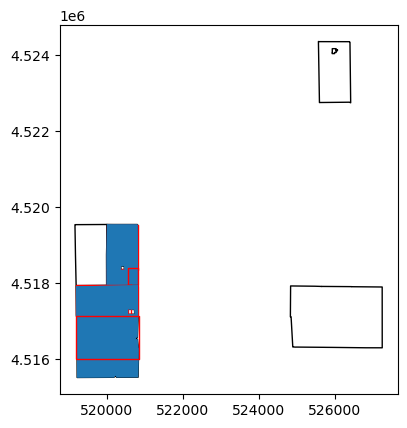

In [13]:
#pasture = '22E'
#group = 'group_3'
fig, ax = plt.subplots()
cper_gdf = gpd.read_file(cper_f)
hfig = display(cper_gdf.plot(ax=ax, color='none', edgecolor='black'), display_id=True, clear=True)

for pasture in tqdm(img_f_dict):
    print('\n\n----------\nPasture: ' + pasture)
    for group in tqdm(img_f_dict[pasture]):
        print('---\nGroup: ' + group)

        # load in approapriate image data
        rgb_f = img_f_dict[pasture][group]['rgb']
        ms_f = img_f_dict[pasture][group]['ms']
        dsm_f = img_f_dict[pasture][group]['dsm']

        # get the bounding box of the pasture
        past_bbox = cper_gdf[cper_gdf['Past_Name_'] == pasture].buffer(
            np.ceil(buff_size * res_fnl * 0.01)).bounds.apply(lambda x: int(x))

        # open image data and mask and rename where appropriate
        rgb_xr = riox.open_rasterio(rgb_f, chunks={'y': chunk_size, 
                                                   'x': chunk_size,
                                                   'band': 1}).sel(band=slice(0, 3), drop=True)
        rgb_xr = rgb_xr.where(rgb_xr != 255).astype('float32')
        ms_xr = riox.open_rasterio(ms_f, chunks={'y': chunk_size,
                                                 'x': chunk_size,
                                                 'band': 1}).sel(band=[4, 3], drop=True)
        ms_xr = ms_xr.where(ms_xr != 65535)
        dsm_xr = riox.open_rasterio(dsm_f, chunks={'y': chunk_size,
                                                   'x': chunk_size}).squeeze().drop('band')
        dsm_xr.name = 'DSM'
        dsm_xr = dsm_xr.where(dsm_xr > 0)

        # subset image data to pasture boundaries
        rgb_xr = rgb_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']),
                            drop=True)

        ms_xr = ms_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']),
                          drop=True)

        dsm_xr = dsm_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']),
                            drop=True)

        # get count of any null data remaining in imagery within pasture boundaries
        ms_ct_null = ms_xr.isel(band=0).isnull().sum().compute()
        dsm_ct_null = dsm_xr.isnull().sum().compute()

        # if more than 1% of the multispectral data is null
        # get the largest rectangle (to nearest 10 m) of non-null multispectral data
        if (ms_ct_null/(ms_xr.shape[1]*ms_xr.shape[2])) > 0.01:
            # coarsen imagery to approximately 10 m
            ms_1m_coarse_val = int(10.0/ms_xr.rio.resolution()[0])
            ms_1m_res = ms_1m_coarse_val * ms_xr.rio.resolution()[0]
            ms_1m = ms_xr.isel(band=1).notnull().astype('int').coarsen(x=ms_1m_coarse_val,
                                                                      y=ms_1m_coarse_val, boundary='trim').max().compute()

            # get the size of the largest rectangle with no null values
            cln_rect = max_size(ms_1m.values, value=1)
            cln_rect

            # get the number of rows and columns to iterate through to find lower-left coords of non-null rectangle
            x_chk_n = (ms_1m.x.max() - (ms_1m.x.min() + ((cln_rect[1] - 1) * ms_1m_res))) / ms_1m_res + 1
            y_chk_n = (ms_1m.y.max() - (ms_1m.y.min() + ((cln_rect[0] - 1) * ms_1m_res))) / ms_1m_res + 1

            # iterate through the rows and columns and save all starting coordinates with non-null rectangles
            x_cln_list = []
            y_cln_list = []
            for x in tqdm(np.arange(ms_1m.x.min(), ms_1m.x.min() + x_chk_n * ms_1m_res, ms_1m_res)):
                for y in np.arange(ms_1m.y.min(), ms_1m.y.min() + y_chk_n * ms_1m_res, ms_1m_res):
                    chk_null = (ms_1m.sel(x=slice(x, x + cln_rect[1] * ms_1m_res-1),
                                         y=slice(y + cln_rect[0] * ms_1m_res-1, y)) == 1).all()
                    if chk_null:
                        x_cln_list.append(x)
                        y_cln_list.append(y)


            # save the minimum starting coordinates
            coords_cln = pd.Series({'x': x_cln_list[np.argmin(y_cln_list)], 'y': np.min(y_cln_list)})
            coords_cln

            # update the extent of the multispectral image and rechunk for NDVI calc later
            ms_xr = ms_xr.sel(y=slice(coords_cln['y'] + cln_rect[0]*ms_1m_res, coords_cln['y']), 
                              x=slice(coords_cln['x'], coords_cln['x'] + cln_rect[1]*ms_1m_res)).chunk({'y': 500, 'x': 500, 'band': -1})

        # if more than 1% of the RGB DSM data is null
        # get the largest rectangle (to nearest 10 m) of non-null RGB DSM data
        if (dsm_ct_null/(dsm_xr.shape[0]*dsm_xr.shape[1])) > 0.01:
            # coarsen imagery to approximately 10 m
            dsm_1m_coarse_val = int(10.0/dsm_xr.rio.resolution()[0])
            dsm_1m_res = dsm_1m_coarse_val * dsm_xr.rio.resolution()[0]
            dsm_1m = dsm_xr.notnull().astype('int').coarsen(x=dsm_1m_coarse_val,
                                                            y=dsm_1m_coarse_val, boundary='trim').max().compute()

            # get the size of the largest rectangle with no null values
            cln_rect = max_size(dsm_1m.values, value=1)
            cln_rect

            # get the number of rows and columns to iterate through to find lower-left coords of non-null rectangle
            x_chk_n = (dsm_1m.x.max() - (dsm_1m.x.min() + ((cln_rect[1] - 1) * dsm_1m_res))) / dsm_1m_res + 1
            y_chk_n = (dsm_1m.y.max() - (dsm_1m.y.min() + ((cln_rect[0] - 1) * dsm_1m_res))) / dsm_1m_res + 1

            # iterate through the rows and columns and save all starting coordinates with non-null rectangles
            x_cln_list = []
            y_cln_list = []
            for x in tqdm(np.arange(dsm_1m.x.min(), dsm_1m.x.min() + x_chk_n * dsm_1m_res, dsm_1m_res)):
                for y in np.arange(dsm_1m.y.min(), dsm_1m.y.min() + y_chk_n * dsm_1m_res, dsm_1m_res):
                    chk_null = (dsm_1m.sel(x=slice(x, x + cln_rect[1] * dsm_1m_res-1),
                                         y=slice(y + cln_rect[0] * dsm_1m_res-1, y)) == 1).all()
                    if chk_null:
                        x_cln_list.append(x)
                        y_cln_list.append(y)


            # save the minimum starting coordinates
            coords_cln = pd.Series({'x': x_cln_list[np.argmin(y_cln_list)], 'y': np.min(y_cln_list)})
            coords_cln

            # update the extent of the RGB and DSM images
            rgb_xr = rgb_xr.sel(y=slice(coords_cln['y'] + cln_rect[0]*dsm_1m_res, coords_cln['y']), 
                              x=slice(coords_cln['x'], coords_cln['x'] + cln_rect[1]*dsm_1m_res),
                                drop=True)
            dsm_xr = dsm_xr.sel(y=slice(coords_cln['y'] + cln_rect[0]*dsm_1m_res, coords_cln['y']), 
                              x=slice(coords_cln['x'], coords_cln['x'] + cln_rect[1]*dsm_1m_res),
                                drop=True)

        del ms_ct_null, dsm_ct_null    
        client.run(gc.collect)
        client.run(trim_memory)
        # get the minimum bounding box of all non-null data
        past_bbox['minx'] = max(rgb_xr.x.min().values, ms_xr.x.min().values, dsm_xr.x.min().values, past_bbox['minx'])
        past_bbox['miny'] = max(rgb_xr.y.min().values, ms_xr.y.min().values, dsm_xr.y.min().values, past_bbox['miny'])
        past_bbox['maxx'] = min(rgb_xr.x.max().values, ms_xr.x.max().values, dsm_xr.x.max().values, past_bbox['maxx'])
        past_bbox['maxy'] = min(rgb_xr.y.max().values, ms_xr.y.max().values, dsm_xr.y.max().values, past_bbox['maxy'])
        
        total_bounds = {'xmin': past_bbox['minx'],
                        'xmax': past_bbox['maxx'],
                        'ymin': past_bbox['miny'],
                        'ymax': past_bbox['maxy']}
        
        n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
        n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))

        
        # subset image data to the updated pasture subset boundaries
        rgb_xr = rgb_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']), 
                            drop=True)

        ms_xr = ms_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']),
                          drop=True)

        dsm_xr = dsm_xr.sel(y=slice(past_bbox['maxy'], past_bbox['miny']), 
                            x=slice(past_bbox['minx'], past_bbox['maxx']), 
                            drop=True)
        
        # plot the current pasture and bounding box of the analsis area in the output preview
        cper_gdf[cper_gdf['Past_Name_'] == pasture].plot(ax=ax)
        gpd.GeoSeries(Polygon([(past_bbox['minx'], past_bbox['miny']),
                 (past_bbox['minx'], past_bbox['maxy']),
                 (past_bbox['maxx'], past_bbox['maxy']),
                 (past_bbox['maxx'], past_bbox['miny'])])).plot(ax=ax, edgecolor='red', color='none')
        fig.canvas.draw()
        hfig.update(fig)

        outSHP = os.path.join(outDIR, 'burrow_pts_pred_' + '_'.join([pasture, group]) + '_' + '_'.join(inputs_fnl + [str(res_fnl)]) + 'cm.shp')
        if os.path.exists(outSHP):
            gdf_out = gpd.read_file(outSHP)
            r_ct_pred = len(gdf_out)
            rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
        elif os.path.exists(re.sub('.shp', '.csv', outSHP)):
            gdf_out = pd.read_csv(re.sub('.shp', '.csv', outSHP))
            r_ct_pred = len(gdf_out)
            rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
        else:
            r_ct_pred = 0
            gdf_out = gpd.GeoDataFrame()
            rc_completed = []

        try:
            client.restart(timeout=9)
            time.sleep(10)
        except TimeoutError:
            client.shutdown()
            client.close()
            cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
            client = Client(cluster)
            client.amm.start()
            
        for full_r in range(n_row_tiles):
            print('running row: ' + str(full_r) + ' of ' + str(n_row_tiles))
            for full_c in tqdm(range(n_col_tiles)):
                if len(client.cluster.workers) < 8:
                    client.shutdown()
                    client.close()
                    cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                    client = Client(cluster)
                    client.amm.start()
                if '_'.join([str(full_r), str(full_c)]) in rc_completed:
                    #print('skipping row/column combination, already in shapefile!')
                    continue
                else:
                    try:
                        t0=time.time()
                        ll = [full_c * full_tile_size + total_bounds['xmin'],
                              full_r * full_tile_size + total_bounds['ymin']]
                        ul = [ll[0], ll[1] + full_tile_size]
                        ur = [x + full_tile_size for x in ll]
                        lr = [ll[0] + full_tile_size, ll[1]]

                        image_dict = {}
                        newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
                        newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))
                        if 'rgb' in inputs_fnl:
                            #print('getting RGB')
                            t1=time.time()
                            image_dict['rgb'] = rgb_xr.sel(x=slice(ll[0], lr[0]),
                                                           y=slice(ul[1], ll[1]), 
                                                           drop=True).rio.reproject(
                                rgb_xr.rio.crs,
                                shape=(newsize_r, newsize_c),
                                resampling=Resampling.bilinear).values
                            #rgb_xr.close()
                            t2=time.time()
                            #print('... completed in', round(t2 - t1, 1), 'secs')
                        if 'dsm' in inputs_fnl:
                            t1 = time.time()
                            #print('getting DSM')
                            image_dict['dsm'] = dsm_xr.sel(x=slice(ll[0], lr[0]),
                                                           y=slice(ul[1], ll[1]), 
                                                           drop=True).squeeze().rio.reproject(
                                dsm_xr.rio.crs,
                                shape=(newsize_r, newsize_c),
                                resampling=Resampling.bilinear).values
                            #dsm_xr.close()
                            t2=time.time()
                            #print('... completed in', round(t2 - t1, 1), 'secs')
                        if 'tpi' in inputs_fnl: 
                            t1 = time.time()
                            #print('computing TPI')
                            # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
                            outer_radius = "0.75m"
                            inner_radius = "0.25m"
                            image_dict['tpi'] = calc_tpi(dsm_xr.sel(x=slice(ll[0], lr[0]),
                                                                    y=slice(ul[1], ll[1]),
                                                                    drop=True).squeeze().rio.reproject(
                                dsm_xr.rio.crs,
                                shape=(newsize_r, newsize_c),
                                resampling=Resampling.bilinear).chunk({'x': chunk_size,
                                                                       'y': chunk_size}), inner_r=inner_radius, outer_r=outer_radius, values=True)
                            #dsm_xr.close()
                            t2=time.time()
                            #print('... completed in', round(t2 - t1, 1), 'secs')
                        if 'ndvi' in inputs_fnl:
                            t1 = time.time()
                            #print('computing NDVI')
                            image_dict['ndvi'] = calc_ndvi(ms_xr.sel(x=slice(ll[0], lr[0]),
                                                                     y=slice(ul[1], ll[1]), 
                                                                     drop=True).rio.reproject(
                                ms_xr.rio.crs,
                                shape=(newsize_r, newsize_c),
                                resampling=Resampling.bilinear), values=True)
                            #ms_xr.close()
                            t2=time.time()
                            #print('... completed in', round(t2 - t1, 1), 'secs')

                        if 'rgb' in image_dict:
                            tshape = image_dict['rgb'].shape[1:]
                        else:
                            tshape = image_dict[inputs_fnl[0]].shape

                        n_row_chunks = int(np.ceil(tshape[0]/tile_size))
                        n_col_chunks = int(np.ceil(tshape[1]/tile_size))

                        pr_mask = np.empty(tshape)
                        t1 = time.time()
                        #print('predicting binary burrow image')
                        for r in range(n_row_chunks):
                            if (r + 1) * tile_size > tshape[0]:
                                r_min = tshape[0] - tile_size
                                r_max = tshape[0]
                                r_max_comp = tshape[0]
                            elif (r + 1) * tile_size + buff_size > tshape[0]:
                                r_min = r * tile_size
                                r_max = (r + 1) * tile_size
                                r_max_comp = r_max
                            else:
                                r_min = r * tile_size
                                r_max = (r + 1) * tile_size
                                r_max_comp = r_max + buff_size
                            for c in range(n_col_chunks):
                                image_sub_dict = {}
                                if (c + 1) * tile_size > tshape[1]:
                                    c_min = tshape[1] - tile_size
                                    c_max = tshape[1]
                                    c_max_comp = tshape[1]
                                elif (c + 1) * tile_size + buff_size > tshape[1]:
                                    c_min = c * tile_size
                                    c_max = (c + 1) * tile_size
                                    c_max_comp = c_max
                                else:
                                    c_min = c * tile_size
                                    c_max = (c + 1) * tile_size
                                    c_max_comp = c_max + buff_size
                                for k in image_dict:
                                    if k == 'rgb':
                                        image_sub_dict[k] = image_dict[k][:,
                                                                          slice(max(0, r_min-buff_size), r_max_comp),
                                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                    else:
                                        image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                    if len(image_sub_dict[k].shape) == 2:
                                        image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                                if preprocess:
                                    for i in image_sub_dict:
                                        image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                                image_list = [image_sub_dict[i] for i in inputs_fnl]
                                image_out = np.concatenate(image_list, axis=0)
                                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                                if type(best_model) == nn.DataParallel:
                                    pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                                    if pred_tmp.shape[1] > tile_size:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                    else:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                                else:
                                    pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                                    if pred_tmp.shape[1] > tile_size:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                    else:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')
                        t1 = time.time()
                        #print('getting burrow locations')
                        pr_labels = label(pr_mask)
                        pr_regions = regionprops(pr_labels)
                        if len(pr_regions) == 0:
                            #print('no burrow locations found!')
                            gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                            gdf_tmp['tile_row'] = full_r
                            gdf_tmp['tile_col'] =  full_c
                            gdf_tmp['tile_size'] = full_tile_size
                            gdf_out = pd.concat([gdf_out, gdf_tmp])
                            del gdf_tmp
                            r_ct_pred += 1
                        else:
                            for r in pr_regions:
                                if r.area*(res_fnl/100)**2 > 0.05:
                                    gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, index=[r_ct_pred]), geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                                                                                        ul[1] - r.centroid[0]*(res_fnl*0.01)])], crs='EPSG:32613')
                                    gdf_tmp['tile_row'] = full_r
                                    gdf_tmp['tile_col'] =  full_c
                                    gdf_tmp['tile_size'] = full_tile_size
                                    gdf_out = pd.concat([gdf_out, gdf_tmp])
                                    if type(gdf_out) is pd.core.frame.DataFrame:
                                        gdf_out = gpd.GeoDataFrame(gdf_out, geometry = gdf_out['geometry'])
                                    del gdf_tmp
                                    r_ct_pred += 1
                        t2=time.time()
                        #print('... completed in', round(t2 - t1, 1), 'secs')
                        if type(gdf_out) is pd.core.frame.DataFrame:
                            gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
                        else:
                            gdf_out.to_file(outSHP)
                        del pr_mask, pred_tmp, pr_labels, pr_regions, image_dict, image_sub_dict, image_list, image_out
                        client.run(gc.collect)
                        client.run(trim_memory)
                        if full_c % 2 == 0:
                            try:
                                client.restart(timeout=9)
                                time.sleep(10)
                            except TimeoutError:
                                client.shutdown()
                                client.close()
                                cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                                client = Client(cluster)
                                client.amm.start()
                            
                        #client.restart()
                    except NoDataInBounds:
                        continue
                        #print('No data in bounds. Skipping row/column.')
            if not '_'.join([str(full_r), str(full_c)]) in rc_completed:
                try:
                    client.restart(timeout=9)
                    time.sleep(10)
                except TimeoutError:
                    client.shutdown()
                    client.close()
                    cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                    client = Client(cluster)
                    client.amm.start()
        print('Pasture-group finished!')
        